## Mini-Lab: Logistic Regression and SVMs

## Names:
David Samuel
James Hancock
Alexandra Fisher
Remy Lagrois

This notebook will illustrate tools used for classification of the MNIST handwritten digits data set.  

We will first split the training data into testing and training objects using sklearn, then scale the data, and analyze weights using logistic regression.  We will then use support vector machines using a linear kernel and compare the speed and accuracy of each of these classification methods. 

# The Business Justification
 This data was collected in order to train a prediction algorithm to correctly identify handwritten digits from 0 to 9 from the MNIST training set.  The data was sourced from Kaggle’s Digit Recognizer competition at the following site: https://www.kaggle.com/c/digit-recognizer/data.  The objective of the competition is to build a fast and effective process for classifying and identifying handwritten characters using computer image processing, and machine learning. By measuring the percentage correctly predicted from the test set, we can gauge the effectiveness of the algorithm.  Achieving a 95% or above accuracy is considered a success rate. Since Kaggle is an open project competition, it fosters various types of collaboration and algorithm benchmarking, this is a  great way to enhance our Data Science learning.
    hand written digit recognition has numerous applications in computer vision.  Banks use automatic cashing of hand written checks, sorting mail by zipcode, and potentially reconstructing shredded files.  Further research into handwritten alphabet recognition has lead to novel advancements such as Google Maps' use of gps and streetview images of actual home address numbers to locate street addresses.

# The Data
There are 2 data sets to work with, the first being the training set, and the second, smaller test set. The training set is comprised of 42,000 rows each representing handwritten digits with 784 pixels or 28 pixels squared.  The training set also includes a label for each observation.  The pixel columns are indexed from pixel0 to pixel783 as a minified RGB value; ordinal measures of color between 0 and 255 inclusive.  Because these images are greyscale, all red, green, and blue values are equal to the same ordinal number.  A solid black, for example, would have an (R,G,B) value of (0, 0, 0), and to conserve memory, this value is stored as a singleton pixel equal to (0).  In contrast, white holds a value of (255); and greyscale is an integer value anywhere in this range.  Each row is identified by the first column “label”, which is a nominal integer value, 0 through 9; these are the 10 classes of digits contained in the set.  These labels will be used as class variables for training.  
    The test data set is 28,000 rows, with labels omitted, and independent of the the training data.

Loading the data. Due to the extremely large amount of dimensions involved in this data set, it was decided to reduce the volume of rows to only 1000. This is due to the fact that a logistic regression will perfrom a lot of functions within memory.

In [1]:
import pandas as pd

# create data frame of training set
df = pd.read_csv('data/train.csv') 

# check distribution of class labels
df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

# Logistic Regression
The Logistic Regression Model is designed to help predict a binary outcome on a categorical data set. For the data set used the categories will consist of the general pixel positions of the handwritten letter data.

The below code is used to get the correct labels for each of the variables of the data set, as well as assure that the X and Y axes are representive of the data model for plotting purposes. A Shufflesplit is also perfromed on the data set, in order to split data into training and test sets.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split  # We will try the method train_test_split instead of ShuffleSplit

# set X and y
X = df.values; y = df['label'].values

# try holding out the test set at 50/50
# random state can be changed, but will calibrate with 0
    
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)  # create x and y training set

# We will now check the distribution of the split

In [4]:
# Check distributions of split
# https://seaborn.pydata.org/tutorial/distributions.html

# print frequency for each of the training and testing sets

print 'Training Class Frequency: ','\n',pd.Series(X_train[:,0]).value_counts(); print '\n'

print 'Testing Class Frequency: ','\n',pd.Series(X_test[:,0]).value_counts()


Training Class Frequency:  
1    2329
7    2210
3    2160
9    2109
8    2072
0    2068
6    2060
4    2046
2    2045
5    1901
dtype: int64


Testing Class Frequency:  
1    2355
7    2191
3    2191
2    2132
9    2079
6    2077
0    2064
4    2026
8    1991
5    1894
dtype: int64


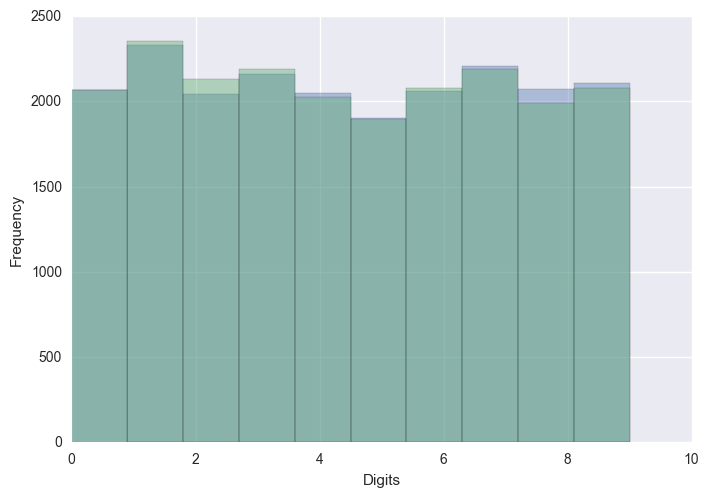

In [5]:
%matplotlib inline
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# Plot a distribution histogram of training and testing sets
for p in [y_train, y_test]: 
    ax = sns.distplot(p, bins=10, hist=True, kde=False)
      
ax.set(xlabel='Digits', ylabel='Frequency')
plt.show()

# The plots below show a bivariate comparison of classes from each set and their kernel densities

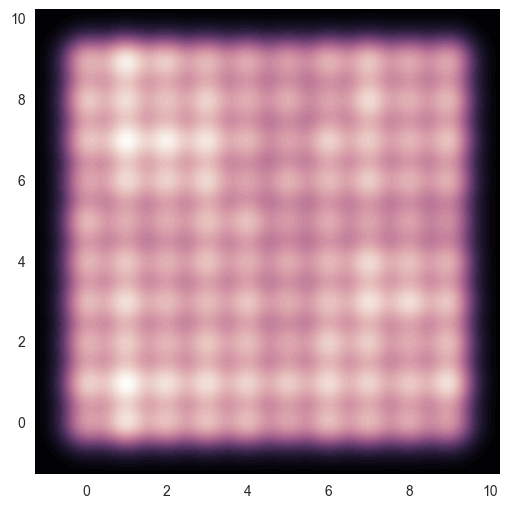

In [6]:
# The code below plots the class densities in a cube helix which shows many more contours
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(y_test, y_train, cmap=cmap, n_levels=60, shade=True);

# Now that we have valid training and testing sets derived from our given training set, we can use PCA to reduce dimensionality and run logistic regression and a SVM model

When the tests above were being performed it was realized that the data was possibly consistent of too many variables, as it took quite some time to perform the log regrssion and other features. With that it was determined that a PCA for dimention reduction would be a great use of tools for this project.

The code below is pulled from Kaggle and is a well designed pre canned PCA for Pandas. 

In [2]:
# Code adapted from 
# https://www.kaggle.com/yessergire/digit-recognizer/logistic-regression/code

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import optimize

# Load Data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test.index.name = 'ImageId'
test.index = test.index + 1

y = train.label.values
X = train.iloc[:,1:].values / 255.0 # Normalize image values
test_data = test.values / 255.0

# Visualize the image data
n = 10
plt.rcParams["figure.figsize"] = (5, 5)
f, axes = plt.subplots(n, n)
plt.tight_layout()
f.subplots_adjust(hspace=-0.1, wspace=0.1)
for i in range(n):
    for j in range(n):
        axes[i, j].imshow(X[i*n + j].reshape((28, 28)), cmap="gray")
        axes[i, j].axis('off')
plt.savefig("digits.png")

# Define size variables
TRAIN_SET_SIZE, N_FEATURES = X.shape
TEST_SET_SIZE, _ = test_data.shape
VALID_SET_SIZE = 10000
MAX_ITERATIONS = 15
LABELS = 10

# Add a bias term to image data
b = np.ones((TRAIN_SET_SIZE, 1))
X = np.hstack((b, X))

b = np.ones((TEST_SET_SIZE, 1))
test_data = np.hstack((b, test_data))


def sigmoid(Z):
    return 1.0 / (1 + np.exp(-Z))

def logistic_cost(X, y, theta):
    H = sigmoid(X.dot(theta))
    return -(y.dot(np.log(H)) + (1 - y).dot(np.log(1 - H))).mean()

def logistic_gradient(X, y, theta):
    H = sigmoid(X.dot(theta))
    return X.T.dot(H - y) / y.size

def one_vs_all(X, Y):
    # This method trains a single classifier per class. Each sample of that class
    # is treated as a positive sample and the rest of the data are treated as negatives.
    # This method returns the weights associated with each class as a matrix.

    W = np.zeros((LABELS, N_FEATURES + 1))
    init_theta = np.zeros(N_FEATURES + 1)

    options = {
        "maxiter": MAX_ITERATIONS
    }

    for label in range(LABELS):
        cost = lambda t: logistic_cost(X, Y == label, t)
        prime = lambda t: logistic_gradient(X, Y == label, t)
        res = optimize.minimize(cost, init_theta, method="L-BFGS-B", jac=prime, options=options)
        theta = res.x
        W[label, :] = theta.reshape(theta.size)
    return W

def classify(X, W):
    # For each sample in X return the most probable class.
    return np.argmax(W.dot(X.T).T, axis=1)

# The training data is split in to training set and validation set.
N = TRAIN_SET_SIZE  - VALID_SET_SIZE
X_train, Y_train = X[:N], y[:N]
X_valid, Y_valid = X[N:], y[N:]

W = one_vs_all(X_train, Y_train)
prediction = classify(X_valid, W)

accuracy = (Y_valid == prediction).mean()
print("The accuracy of this model is %.2f %%." % (accuracy * 100))

# Train the model with all of the training data.
W = one_vs_all(X, y)
prediction = classify(test_data, W) # Predict labels for the test set

# Save the predictions for submission.
submission = pd.DataFrame(prediction, index=test.index, columns=['Label'])
submission.to_csv("logistic-regression-submission.csv")

The accuracy of this model is 91.26 %.


## Below is code to be tweaked

The code below is what is used to reduce the dimensions and pinpoint the ones most vital to the data set.

In [1]:
# Let's try reducing dimensionality with PCA to 50 components 
# as we have seen from the eigenvectors from lab 1, 50 should be sufficient
from sklearn.decomposition import PCA, KernelPCA
n_comp = 50

pca = PCA(n_components=n_comp, whiten=True)
X_train = pca.fit(X_train)
X_train = pca.transform(X_train)

pca = PCA(n_components=n_comp, whiten=True)
X_test = pca.fit(X_test)
X_test = pca.transform(X_test)
        

NameError: name 'X_train' is not defined

In [ ]:
# Try KernelPCA

# kpca = KernelPCA(kernel="poly", gamma=10, random_state=0)
# X_kpca = kpca.fit_transform(X)
# X_back = kpca.inverse_transform(X_kpca)
# pca = PCA()
# X_pca = pca.fit_transform(X)




Below a logistic regression is run with two variations included in order to assure that the randomized sample used in each interation was representitive of the sample. Within the logistic regression the train indices are defined as well as the accuracy scores for each iteration. 

The two iterations present a 83% and 81.5% respectively. Meaning that the two iterations are fairly similar in nature to one another.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None)


for i in range(10):
    lr_clf.fit(train_, test_) 
    y_hat = lr_clf.predict(test_) 

    acc = mt.accuracy_score(test_,y_hat)
    conf = mt.confusion_matrix(test_,y_hat)
    print("====Iteration",i," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)

TypeError: unhashable type: 'numpy.ndarray'

The below logistic regression is the same test with just a shorter code set. The accuracies listed in the output below are also very similar to those we recieved from the previous problem.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

import time
start = time.time()

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) 
from sklearn.cross_validation import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) 
print('time: ', time.time()-start)
print(accuracies)

Below is a widget that helps one determine the various accuracy percentages given various levels of cost. We can see that the accuracy stays reletively constant, except that the accuracy goes down as the cost is lowered on the slider.

In [ ]:
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None)
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) 
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05))

Below a standard scaler is run. The standard scaler is designed to standardize features by removing the mean and scaling to unit variance. Due to the fact that this data set has a very large amount of elements the findings from this test will be fairly ambiguous, however it is important to note that the values do step down when moving down the scale.

In [ ]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
# zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

Now it is time to plot the weights to show where the numbers might lie in determination of which attributes are most important when predicting. As stated presviouly this data set is a little odd in determination of variable selection however we can see that the pixels in the middle of the data set, show to a much greater extent where the possible future values may lie.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
sns = weights.plot(color = "blue")

Below a pipeline is used to help to a greater extent which values are the largest deterininents. A pipline essentially applies a list of transforms along with a final estimator. The final estimator only needs to implement fit. From this we can determine which of the variables is most vital for model creation. As shown in the output the values toward the middle of the pixel scale appear to be the most likely determininents which is to be expected as most of the items would be drawn centered arond the middle of the box.

In [ ]:
# Ignore warnings


from sklearn.pipeline import Pipeline
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  
    
trained_model_from_pipeline = piped_object.named_steps['logit_model']

weights = pd.Series(trained_model_from_pipeline.coef_[0],index=df.columns)
sns = weights.plot(color = "red")

# Support Vector Machines¶
Scaled attributes from the training and testing data are now used for investigating associated weights and support vectors. This is done by using support vector machines (SVMs) on the data and playing with the parameters.

In [3]:
# Code sampled from https://www.kaggle.com/jimmylian/digit-recognizer/svm-and-pca-in-sklearn/code

import numpy
from sklearn.decomposition import PCA
from sklearn.svm import SVC

COMPONENT_NUM = 50
print('Read training data...')
with open('data/train.csv', 'r') as reader:
    reader.readline()
    train_label = []
    train_data = []
    for line in reader.readlines():
        data = list(map(int, line.rstrip().split(',')))
        train_label.append(data[0])
        train_data.append(data[1:])
print('Loaded ' + str(len(train_label)))

print('Reduction...')
train_label = numpy.array(train_label)
train_data = numpy.array(train_data)
pca = PCA(n_components=COMPONENT_NUM, whiten=True)
pca.fit(train_data)
train_data = pca.transform(train_data)

print('Train SVM...')
svc = SVC()
svc.fit(train_data, train_label)

print('Read testing data...')
with open('data/test.csv', 'r') as reader:
    reader.readline()
    test_data = []
    for line in reader.readlines():
        pixels = list(map(int, line.rstrip().split(',')))
        test_data.append(pixels)
print('Loaded ' + str(len(test_data)))

print('Predicting...')
test_data = numpy.array(test_data)
test_data = pca.transform(test_data)
predict = svc.predict(test_data)

print('Saving...')
with open('predict.csv', 'w') as writer:
    writer.write('"ImageId","Label"\n')
    count = 0
    for p in predict:
        count += 1
        writer.write(str(count) + ',"' + str(p) + '"\n')
        


Read training data...
Loaded 42000
Reduction...
Train SVM...
Read testing data...
Loaded 28000
Predicting...
Saving...


/Users/majickdave/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


AttributeError: 'bool' object has no attribute 'mean'